In [7]:
from src import *
import warnings
warnings.filterwarnings("ignore")

## Table of Contents
- [Timeseries Comparison](#comparison)
- [GLM](#weightings)

<a class="anchor" id="comparison"></a>
### Generating metric emotion correlation tables

In [46]:
networks = list(index2region.keys())

select   = ['Anger','Guilt','WarmHeartedness', \
             'Disgust','Happiness','Fear','Contempt','Anxiety', \
             'Satisfaction','Shame','Surprise','Love','Sad']

In [21]:
movienames = [moviename.split('_')[0] for moviename in os.listdir('./resources/dynamic_grad/group_level414')]

In [ ]:
for moviename in tqdm(movienames[9:]):
    if moviename == "Rest": continue
    # 1. Loading Gradient
    G_movie, varM = load('./resources/dynamic_grad/group_level414/{}_40_grad.pkl'.format(moviename))
    
    # 2. Loading Matching Emotion Track
    if moviename == 'BetweenViewing':
        moviename += 's'
    full_df  = pd.read_csv('./data/emoFiles/emotion_compile.csv')
    emo_df   = full_df[full_df['filename']=='W_{}13.csv'.format(moviename)]
    other_df = full_df[full_df['filename']!='W_{}13.csv'.format(moviename)]

    # Grid for each network of correlation with emotions
    grad_idx = 0
    smfactor = 1
    tolshift = 0

    n = len(networks)
    m = len(select)

    pairs = [("Vis", "Default"), ("SomMot", "Default"), 
            ("SomMot", "Vis"), ("DorsAttn", "SalVentAttn"),
            ("DorsAttn", "Default"), ("Limbic", "Default"), ("Cont", "Default")]
    nb_metric = 6
    scores  = np.zeros((nb_metric, n,m))
    nscores = np.zeros((nb_metric, n,m))

    # METRIC 1
    for idx, pair in enumerate(tqdm(pairs)):
        p1,p2 = pair
        y = np.asarray([networks_distance(G_movie[t], G_movie[t], p1, p2) 
                        for t in range(len(G_movie))])
        z1 = zscore(y)
        for jdx, emotion in enumerate(select):
            concat_other = np.array(other_df[other_df.item == emotion]['score'])
            emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
            smoothened = overlap_add(emo_series, smfactor)
            z2   = zscore(smoothened[:z1.shape[0]])

            _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
            nscores[0, idx,jdx] = nscore
            scores[0, idx,jdx]  = corr           

    # # METRIC 2
    # for idx, R in enumerate(tqdm(networks)):
    #     y  = network_variance(G_movie, R, grad_idx)
    #     z1 = zscore(y)

    #     for jdx, emotion in enumerate(select):
    #         concat_other = np.array(other_df[other_df.item == emotion]['score'])
    #         emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
    #         smoothened = overlap_add(emo_series, smfactor)
    #         z2   = zscore(smoothened[:z1.shape[0]])

    #         _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
    #         nscores[1, idx,jdx] = nscore
    #         scores[1, idx,jdx]  = corr        

    # METRIC 3
    for idx, R in enumerate(tqdm(networks)):
        y  = np.asarray([network_volume(G_movie[t], R) 
                        for t in range(len(G_movie))])
        z1 = zscore(y)

        for jdx, emotion in enumerate(select):
            concat_other = np.array(other_df[other_df.item == emotion]['score'])
            emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
            smoothened = overlap_add(emo_series, smfactor)
            z2   = zscore(smoothened[:z1.shape[0]])

            _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
            nscores[2, idx,jdx] = nscore
            scores[2, idx,jdx]  = corr

    # METRIC 4
    for idx, R in enumerate(tqdm(networks[:-3])):
        y  = varM[:,idx]
        z1 = zscore(y)

        for jdx, emotion in enumerate(select):
            concat_other = np.array(other_df[other_df.item == emotion]['score'])
            emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
            smoothened = overlap_add(emo_series, smfactor)
            z2   = zscore(smoothened[:z1.shape[0]])

            _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
            nscores[3, idx,jdx] = nscore
            scores[3, idx,jdx]  = corr


    # METRIC 5 first 7 region of subcortical
    for idx, R in enumerate(tqdm(networks)):
        tmpA = G_movie[:, 400+idx][:-1]
        tmpB = G_movie[:, 400+idx][1:]

        y  = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
                            for pidx in range(len(tmpA))])
        z1 = zscore(y)

        for jdx, emotion in enumerate(select):
            concat_other = np.array(other_df[other_df.item == emotion]['score'])
            emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
            smoothened = overlap_add(emo_series, smfactor)
            z2   = zscore(smoothened[:z1.shape[0]])

            _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
            nscores[4, idx,jdx] = nscore
            scores[4, idx,jdx]  = corr

    # METRIC 6 second set of 7 region of subcortical
    for idx, R in enumerate(tqdm(networks)):
        tmpA = G_movie[:, 407+idx][:-1]
        tmpB = G_movie[:, 407+idx][1:]

        y  = np.asarray([ points_distance(tmpA[pidx], tmpB[pidx], pmethod="L2") 
                            for pidx in range(len(tmpA))])
        z1 = zscore(y)

        for jdx, emotion in enumerate(select):
            concat_other = np.array(other_df[other_df.item == emotion]['score'])
            emo_series = np.array(emo_df[emo_df.item==emotion]['score'])
            smoothened = overlap_add(emo_series, smfactor)
            z2   = zscore(smoothened[:z1.shape[0]])

            _, nscore, corr = moviemix_stat_test(z1, z2, concat_other)
            nscores[5, idx,jdx] = nscore
            scores[5, idx,jdx]  = corr

    save('./resources/emo_metric_table/{}.pkl'.format(moviename),(nscores,scores))

  0%|                                                                          | 0/7 [00:00<?, ?it/s]

In [47]:
select

['Anger',
 'Guilt',
 'WarmHeartedness',
 'Disgust',
 'Happiness',
 'Fear',
 'Contempt',
 'Anxiety',
 'Satisfaction',
 'Shame',
 'Surprise',
 'Love',
 'Sad']

In [43]:
permovies.keys()

dict_keys(['AfterTheRain', 'FirstBite', 'Chatter', 'BetweenViewings', 'ToClaireFromSonny', 'Sintel', 'LessonLearned', 'TheSecretNumber', 'Superhero', 'YouAgain', 'BigBuckBunny', 'Spaceman', 'TearsOfSteel', 'Payload'])

In [50]:
permovies['Chatter'][[4,5]][:,:,10]

array([[ 0.        , -0.        , -0.15161862, -0.        , -0.        ,
        -0.        , -0.        ],
       [ 0.19554967, -0.        , -0.        , -0.16034344, -0.        ,
         0.        , -0.        ]])

### Analysis of emo-metric-table

In [28]:
permovies   = {}
countmovies = {}
for file in os.listdir('./resources/emo_metric_table/'):
    nscores, scores = load('./resources/emo_metric_table/{}'.format(file))
    chop = (nscores < 0.05) * scores
    permovies[file.split('.')[0]]   = chop
    countmovies[file.split('.')[0]] = np.array(nscores < 0.05 * (scores !=0) , dtype=float)

array([[2., 4., 1., 2., 2., 4., 2., 2., 1., 3., 1., 0., 3.],
       [3., 2., 4., 2., 3., 1., 4., 2., 3., 4., 3., 2., 4.],
       [3., 0., 0., 2., 2., 2., 0., 2., 0., 1., 2., 1., 1.],
       [3., 3., 2., 2., 3., 1., 2., 1., 3., 2., 1., 2., 1.],
       [3., 2., 1., 1., 2., 2., 3., 2., 2., 1., 2., 3., 1.],
       [2., 4., 3., 2., 3., 2., 3., 3., 4., 2., 1., 3., 2.],
       [1., 4., 1., 2., 3., 2., 2., 2., 3., 1., 3., 2., 2.]])

<AxesSubplot:title={'center':'Number of significant correlations'}>

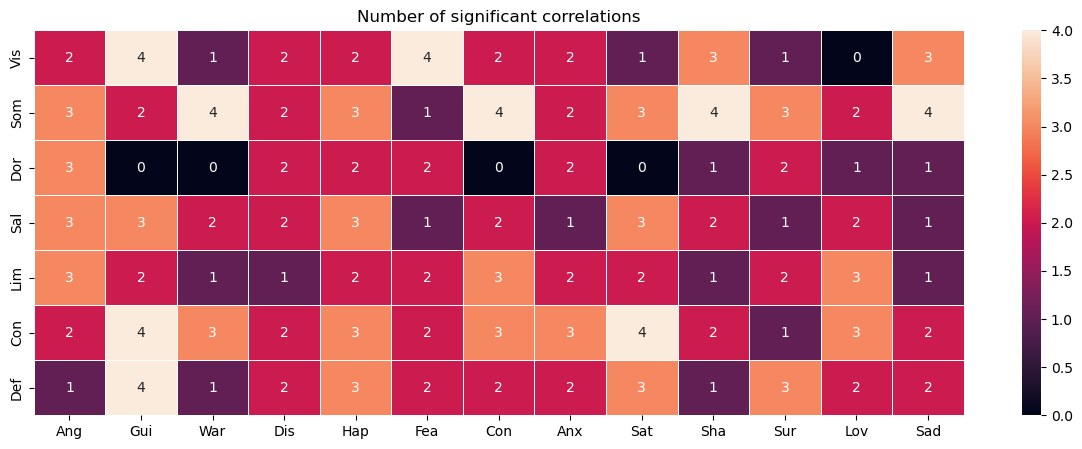

In [63]:
plt.figure(figsize=(15,5))
plt.title("Number of significant correlations")
x_axis_labels = [f[:3] for f in select] # labels for x-axis
y_axis_labels = [f[:3] for f in networks] # labels for x-axis
sns.heatmap(np.asarray(list(countmovies.values())).sum(axis=0)[2], linewidth=0.5,  annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)